In [1]:
!pip install tensorflow-gpu
!pip install keras
!pip install plotly
!pip install cufflinks
!pip install chart_studio

In [3]:
#Imports

import tensorflow
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU, Flatten
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
#import chart_studio.plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
#import chart_studio.plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
#from chart_studio.plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')

Using TensorFlow backend.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:

STOPWORDS = stopwords

In [0]:
#Reading in data

df = pd.read_csv('clean_text.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)

df.dropna(inplace = True)

In [8]:
t = Tokenizer()
t.fit_on_texts(df['clean_text'])
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_text = t.texts_to_sequences(df['clean_text'])
print(encoded_text)
# pad documents to a max length of 4 words
max_length = 500
padded_text = pad_sequences(encoded_text, maxlen=max_length, padding='post')
print(padded_text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[    62      8    280 ...      0      0      0]
 [    10      8    503 ...      0      0      0]
 [     3   9939  46049 ...      0      0      0]
 ...
 [     1    523    254 ...      0      0      0]
 [167981  17071   1468 ...      0      0      0]
 [  1468    948    109 ...      0      0      0]]


In [10]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [45]:
# define model
model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=500, trainable=False)
model.add(e)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

ValueError: ignored

In [0]:
X = padded_text

y = pd.get_dummies(df['label']).values

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

In [43]:
h = model.fit(X, y, batch_size = 128, epochs=100, verbose=1, validation_split= .2)
#callbacks=[EarlyStopping(monitor='val_accuracy', patience=2, min_delta=0.0001)]

Train on 19196 samples, validate on 4800 samples
Epoch 1/100
19196/19196 [==============================] - 6s 327us/sample - loss: 0.4967 - accuracy: 0.7824 - val_loss: 0.1978 - val_accuracy: 0.9393
Epoch 2/100
19196/19196 [==============================] - 6s 308us/sample - loss: 0.2326 - accuracy: 0.9124 - val_loss: 0.2343 - val_accuracy: 0.9169
Epoch 3/100
19196/19196 [==============================] - 6s 305us/sample - loss: 0.1487 - accuracy: 0.9529 - val_loss: 0.3016 - val_accuracy: 0.8891
Epoch 4/100
19196/19196 [==============================] - 6s 303us/sample - loss: 0.1134 - accuracy: 0.9672 - val_loss: 0.1906 - val_accuracy: 0.9323
Epoch 5/100
19196/19196 [==============================] - 6s 308us/sample - loss: 0.0866 - accuracy: 0.9793 - val_loss: 0.3266 - val_accuracy: 0.8865
Epoch 6/100
19196/19196 [==============================] - 6s 306us/sample - loss: 0.0769 - accuracy: 0.9803 - val_loss: 0.2745 - val_accuracy: 0.9051
Epoch 7/100
19196/19196 [====================

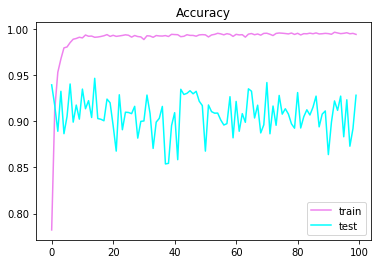

In [44]:
plt.title('Accuracy')
plt.plot(h.history['accuracy'], label='train', color = 'violet')
plt.plot(h.history['val_accuracy'], label='test', color = 'cyan')
plt.legend()
plt.show();

In [48]:
preds = model.predict(X)
pred_label = model.predict_classes(X)

pred_label

array([0, 0, 1, ..., 1, 0, 1])

In [49]:
df['pred'] = pred_label

probs = model.predict_proba(X)

prob_true = []
prob_fake = []

for i in range(len(df.index)):
    prob_true.append(probs[i][0])
    prob_fake.append(probs[i][1])

df['prob_true'] = prob_true
df['prob_fake'] = prob_fake

df.head()
    

,clean_text,label,pred,prob_true,prob_fake
0,U S Secretary of State John F Kerry said Monda...,1,0,0.238054,0.231172
1,It s primary day in New York and front runner ...,1,0,0.345764,0.274369
2,A Czech stockbroker who saved more than 650 Je...,1,1,0.374681,0.569897
3,Hillary Clinton and Donald Trump made some ina...,1,1,0.108573,0.363198
4,Iranian negotiator reportedly have made a last...,1,0,0.227945,0.206285


In [0]:
df.to_csv('nn_preds_df.csv')

In [54]:
df['pred'].value_counts()

1    15155
0     8841
Name: pred, dtype: int64

In [53]:
df['label'].value_counts()

-1    16847
 1     7149
Name: label, dtype: int64

In [0]:
df['label'] = df['label'].map({-1: 1, 1: 0})

In [57]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print(f'The f1 score is {f1_score(df["label"], df["pred"])}')

print(f'The precision score is {precision_score(df["label"], df["pred"])}')

print(f'The recall score is {recall_score(df["label"], df["pred"])}')

The f1 score is 0.6472095494031624
The precision score is 0.6833388320686242
The recall score is 0.6147088502403989


In [58]:
print(f'The accuracy score is {accuracy_score(df["label"], df["pred"])}')

The accuracy score is 0.5295049174862477
